In [1]:
import pandas as pd

ratings_df = pd.read_csv("Dataset/ratings_splits/temporal_global/filtered/train.csv") 

ratings_df_cleaned = ratings_df.drop(columns=['RatingID', 'Date', 'Vintage']).rename(columns={'WineID': 'item', 'UserID': 'user', 'Rating': 'rating'})

display(ratings_df_cleaned.head(10))

,user,item,rating
0,1173759,111415,5.0
1,1075841,111431,5.0
2,1225931,111431,5.0
3,1197513,111415,5.0
4,1173759,135885,5.0
5,1089224,111478,4.5
6,1174133,112229,5.0
7,1141874,111478,5.0
8,1203892,113240,5.0
9,1396037,102547,3.0


In [2]:
wines_df = pd.read_csv('Dataset/last/Xwines_Slim_1K_wines.csv')
wines_df['WineID'] = wines_df.index

In [3]:
print(wines_df.columns)

Index(['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV',
       'Body', 'Acidity', 'Code', 'Country', 'RegionID', 'RegionName',
       'WineryID', 'WineryName', 'Website', 'Vintages'],
      dtype='object')


,UserID
WineID,
100001,289
100002,4
100003,8
100005,10
100007,10
...,...
199408,2
199481,1
199533,3


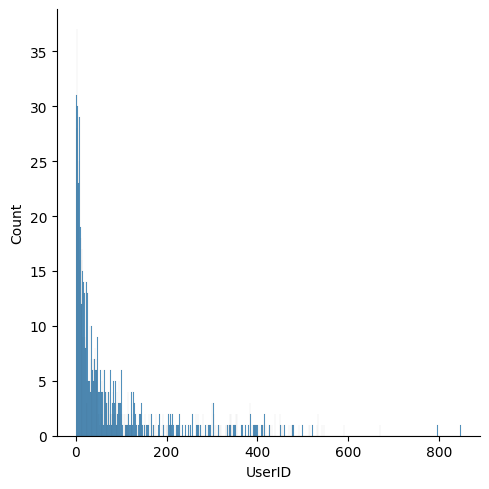

In [4]:
import seaborn as sns

count_ratings_df = ratings_df[['UserID','WineID']].groupby(['WineID']).count()
display(count_ratings_df)
sns.displot(data=count_ratings_df, x='UserID', binwidth=1)

,index,WineID,UserID
0,0,167418,848
1,1,167419,796
2,2,179012,670
3,3,155308,590
4,4,193478,546
...,...,...,...
980,980,150820,1
981,981,185917,1
982,982,186079,1
983,983,106091,1


<Axes: xlabel='index', ylabel='UserID'>

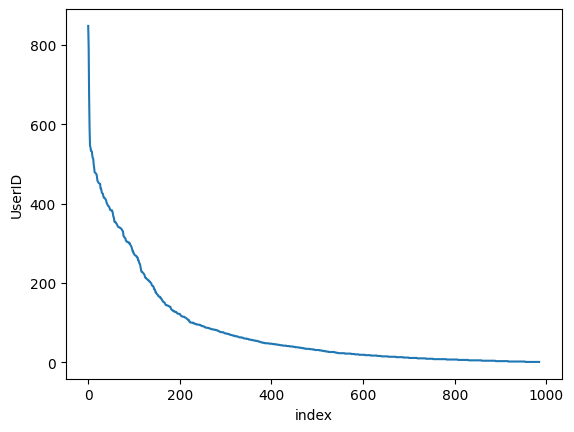

In [5]:
count_ratings_df_ord = count_ratings_df.sort_values(by="UserID", ascending=False).reset_index().reset_index()
display(count_ratings_df_ord)
sns.lineplot(data=count_ratings_df_ord, x='index', y='UserID')

In [6]:
users_ratings = ratings_df_cleaned.groupby(['user']).count()

selected = users_ratings['rating'] > 20
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() 
select_column_df = random_selected.reset_index()['user'] 
selected_user = select_column_df.iloc[0]
print("Selected user: " + str(selected_user))

Selected user: 1165081


In [7]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser


num_recs = 10  
user_user = UserUser(15, min_nbrs=3)  
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df_cleaned)

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


In [8]:
selected_wines_useruser = recsys.recommend(selected_user, 10)
display(selected_wines_useruser)

,item,score
0,144734,4.825650
1,182169,4.682120
2,113321,4.633811
3,175454,4.628808
4,112084,4.598707
5,183379,4.584733
6,194674,4.564776
7,185009,4.559278
8,162497,4.504295
9,137224,4.498669


In [9]:
import pandas as pd

ratings_df_test = pd.read_csv("Dataset/ratings_splits/temporal_global/filtered/test.csv") 

# Remove the 'Date' and 'RatingID' columns and rename 'WineID' to 'Item' and 'UserID' to 'User'
ratings_df_cleaned_test = ratings_df_test.drop(columns=['RatingID', 'Date', 'Vintage']).rename(columns={'WineID': 'item', 'UserID': 'user', 'Rating': 'rating'})

# Display the first 10 rows of the modified DataFrame
# display(ratings_df_cleaned_test.head(10))

In [10]:
selected_wines_useruser = recsys.recommend(selected_user, 1001)
display(selected_wines_useruser)

,item,score
0,144734,4.825650
1,182169,4.682120
2,113321,4.633811
3,175454,4.628808
4,112084,4.598707
...,...,...
673,105364,2.617188
674,181447,2.596454
675,100005,2.558979
676,194820,2.343535


In [11]:
wine_row = ratings_df_cleaned_test[ratings_df_cleaned_test['user'] == selected_user]
print(wine_row)

          user    item  rating
21836  1165081  160277     4.0
27740  1165081  155565     3.0


In [12]:
wine_row_2 = selected_wines_useruser[selected_wines_useruser['item'] == 111433]
print(wine_row_2)

Empty DataFrame
Columns: [item, score]
Index: []


In [13]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.item_knn import ItemItem


num_recs = 10  
itemitem = ItemItem(15, min_nbrs=3)  
recsys_item = Recommender.adapt(itemitem)
recsys_item.fit(ratings_df_cleaned)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenskit\algorithms\item_knn.py:119: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  b = blocks[bi]


In [14]:
selected_wines_itemitem = recsys_item.recommend(selected_user, 1001)
display(selected_wines_itemitem)

,item,score
0,183379,5.010780
1,180330,4.923408
2,132977,4.916152
3,196531,4.902200
4,144337,4.855395
...,...,...
817,142975,2.443518
818,172220,2.420866
819,164987,2.192169
820,193764,2.145696


In [15]:
wine_row = ratings_df_cleaned_test[ratings_df_cleaned_test['user'] == selected_user]
print(wine_row)

          user    item  rating
21836  1165081  160277     4.0
27740  1165081  155565     3.0


In [16]:
wine_row_item = selected_wines_itemitem[selected_wines_itemitem['item'] == 100067]
print(wine_row_item)

       item     score
102  100067  4.141043


In [17]:
wine_ratings_pivot = ratings_df_cleaned.pivot_table(index='item', columns='user', values='rating')

wine_avg_ratings = wine_ratings_pivot.mean(axis=1)
# wine_ratings_filled = wine_ratings_pivot.apply(lambda x: x.fillna(wine_avg_ratings))
wine_ratings_filled = wine_ratings_pivot.apply(lambda x: x.fillna(0))

group_users = [1173759, 1075841, 1225931] 

group_ratings = wine_ratings_filled[group_users].sum(axis=1) / len(group_users)

recommended_wines = group_ratings.sort_values(ascending=False)

print("Recommended wines for the group:")
print(recommended_wines)

Recommended wines for the group:
item
111431    3.333333
170982    2.666667
111478    1.666667
111415    1.666667
135885    1.666667
            ...   
116213    0.000000
116266    0.000000
116418    0.000000
116893    0.000000
200139    0.000000
Length: 985, dtype: float64


In [18]:
for user in group_users:
  ret = ratings_df_cleaned[ratings_df_cleaned['item'] == 170982]
  # print(ret)
  print(ret[ret['user'] == user])
  print('  ')

          user    item  rating
37462  1173759  170982     4.0
  
          user    item  rating
32155  1075841  170982     4.0
  
Empty DataFrame
Columns: [user, item, rating]
Index: []
  
